<a href="https://colab.research.google.com/github/GraceMcPadden2/BERT_fine_tuning/blob/main/stock_rl_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip -q install gymnasium==0.29.1 shimmy>=1.3.0 \
               stable-baselines3==2.3.2 \
               yfinance==0.2.43 numpy pandas matplotlib pandas_datareader


In [5]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import math
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# --- Config ---
TICKERS = ["GLD.US", "SPY.US","IEF.US"]     # Gold, US Equity, US Bonds
LOOKBACK = 60                       # days of history in obs
TRAIN_START, TRAIN_END = "2020-01-01", "2022-12-31"
TEST_START, TEST_END   = "2023-01-01", "2024-12-31"

RISK_FREE = 0.00                    # daily rf ≈ 0 for simplicity
ETA = 1/252                         # EMA scale for Differential Sharpe
SEED = 42
np.random.seed(SEED)


In [7]:
def get_prices(tickers, start, end):
    """Download Close prices from Stooq (sorted ascending)."""
    if isinstance(tickers, str):
        tickers = [tickers]

    data = pd.concat(
        [
            web.DataReader(t, "stooq")[["Close"]]
            .rename(columns={"Close": t})
            .sort_index()
            .loc[pd.to_datetime(start): pd.to_datetime(end)]
            for t in tickers
        ],
        axis=1
    )
    return data.dropna()


prices_train = get_prices(TICKERS, TRAIN_START, TRAIN_END)
prices_test  = get_prices(TICKERS, TEST_START, TEST_END)

# Daily log returns
logret_train = np.log(prices_train / prices_train.shift(1)).dropna()
logret_test  = np.log(prices_test / prices_test.shift(1)).dropna()

display(prices_train.tail(), logret_train.tail())

,GLD.US,SPY.US,IEF.US
Date,,,
2022-12-23,167.26,371.284,96.75
2022-12-27,168.67,369.821,95.94
2022-12-28,167.91,365.225,95.71
2022-12-29,168.85,371.798,96.18
2022-12-30,169.64,370.819,95.78


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,GLD.US,SPY.US,IEF.US
Date,,,
2022-12-23,0.002994,0.005737,-0.004537
2022-12-27,0.008395,-0.003948,-0.008407
2022-12-28,-0.004516,-0.012506,-0.002400
2022-12-29,0.005583,0.017837,0.004899
2022-12-30,0.004668,-0.002637,-0.004168


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
class PortfolioEnv(gym.Env):
    """
    State: last LOOKBACK days of log-returns for each asset, flattened (N*LOOKBACK),
           plus previous weights (N)      -> shape = N*LOOKBACK + N
    Action: unconstrained R^N -> softmax -> long-only weights summing to 1
    Reward: Differential Sharpe (Moody et al.) using EMA updates (ETA)
    Dynamics: daily rebalancing, no tx costs (simple & consistent with the paper's base case)
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, log_returns: pd.DataFrame, lookback=60, eta=1/252, rf=0.0):
        super().__init__()
        self.returns = log_returns.values.astype(np.float32)  # shape [T, N]
        self.dates = log_returns.index
        self.assets = list(log_returns.columns)
        self.N = self.returns.shape[1]
        self.lookback = lookback
        self.eta = eta
        self.rf = rf

        # obs: N*lookback past logrets + previous weights N
        obs_len = self.N * self.lookback + self.N
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_len,), dtype=np.float32)

        # actions: unconstrained R^N (we softmax inside)
        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(self.N,), dtype=np.float32)

        self._reset_buffers()

    def _reset_buffers(self):
        self.t = self.lookback  # current index (first step after we have lookback history)
        self.w_prev = np.ones(self.N, dtype=np.float32) / self.N  # start equal weight
        # Sharpe EMA buffers (Moody):
        self.A = 0.0  # EMA mean of returns
        self.B = 0.0  # EMA mean of squared returns

        self.portfolio_value = 1.0  # normalized

    def _obs(self):
        hist = self.returns[self.t - self.lookback:self.t, :].T.reshape(-1)  # (N*lookback,)
        return np.concatenate([hist, self.w_prev], axis=0).astype(np.float32)

    @staticmethod
    def _softmax(x):
        x = x - np.max(x)
        ex = np.exp(x)
        sm = ex / (np.sum(ex) + 1e-12)
        return sm

    def step(self, action):
        # map action -> weights
        w = self._softmax(action)

        # realize asset returns at t (log-returns); convert to simple gross return:
        r_log = self.returns[self.t, :]            # log returns
        gross = np.exp(r_log)                      # R_t + 1
        # portfolio simple return over t-1 -> t (net of rf if wanted)
        port_gross = float(np.dot(w, gross))
        port_ret = port_gross - 1.0                # simple return

        # Differential Sharpe components (Moody)
        dA = port_ret - self.A
        dB = (port_ret ** 2) - self.B
        A_prev, B_prev = self.A, self.B
        self.A += self.eta * dA
        self.B += self.eta * dB

        denom = (B_prev - A_prev**2)
        if denom <= 1e-12:
            diff_sharpe = 0.0
        else:
            # There's a K_t factor in the paper, but it cancels in practice for signal; keep the core form.
            diff_sharpe = (B_prev * dA - 0.5 * A_prev * dB) / (denom ** 1.5 + 1e-12)

        reward = float(diff_sharpe)

        # advance
        self.portfolio_value *= port_gross
        self.w_prev = w.copy()
        self.t += 1

        terminated = (self.t >= self.returns.shape[0])
        truncated = False

        return self._obs(), reward, terminated, truncated, {"pv": self.portfolio_value, "weights": self.w_prev}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_buffers()
        return self._obs(), {}

    def render(self):
        print(self.dates[self.t], "PV:", self.portfolio_value, "w:", self.w_prev)


In [19]:
def make_env(logret, lookback=LOOKBACK):
    def _init():
        return PortfolioEnv(logret, lookback=lookback, eta=ETA, rf=RISK_FREE)
    return _init

train_env = DummyVecEnv([make_env(logret_train)])
test_env  = DummyVecEnv([make_env(logret_test)])


/tmp/ipython-input-1794723983.py:44: RuntimeWarning: invalid value encountered in divide
  self.w_prev = self.w_prev / self.w_prev.sum()


In [20]:
model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    seed=SEED,
    tensorboard_log=None,
    learning_rate=3e-4,
    n_steps=1024,        # rollout size
    batch_size=256,
    n_epochs=10,
    gamma=0.90,         # shorter horizon, like the paper (gamma≈0.9)
    gae_lambda=0.90,
    clip_range=0.25
)

TIMESTEPS = 200_000   # small for demo; bump to 1-2M for better results
model.learn(total_timesteps=TIMESTEPS)


Using cuda device


/tmp/ipython-input-1794723983.py:44: RuntimeWarning: invalid value encountered in divide
  self.w_prev = self.w_prev / self.w_prev.sum()


ValueError: Expected parameter loc (Tensor of shape (1, 3)) of distribution Normal(loc: torch.Size([1, 3]), scale: torch.Size([1, 3])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0')

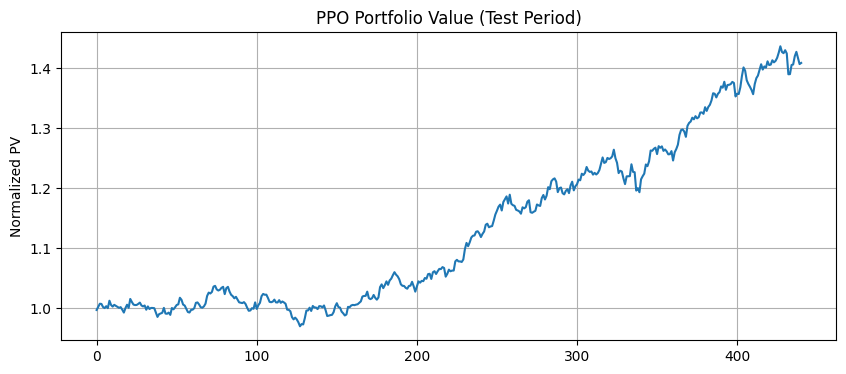

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,GLD.US,SPY.US,IEF.US
436,-0.546607,1.426994,-2.091869
437,1.026203,-0.889919,-0.653819
438,0.503066,-0.574950,-0.968135
439,-0.071925,0.474147,-1.586416
440,0.322726,0.189971,-1.595361


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
def run_policy(env_vec, model):
    env = env_vec.envs[0]   # unwrap DummyVecEnv
    obs, _ = env.reset()
    pvals = [1.0]
    weights = []
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        pvals.append(getattr(env, "portfolio_value", getattr(env, "pv", 1.0)))
        weights.append(action)

    # --- Find a usable index for plotting ---
    # Try price_data, data, df, or fallback to a simple range index
    if hasattr(env, "price_data"):
        dates = env.price_data.index[:len(pvals)-1]
    elif hasattr(env, "data"):
        dates = env.data.index[:len(pvals)-1]
    elif hasattr(env, "df"):
        dates = env.df.index[:len(pvals)-1]
    else:
        dates = pd.RangeIndex(len(pvals)-1)

    # --- Build output ---
    assets = getattr(env, "assets", [f"Asset {i}" for i in range(len(weights[0]))])
    w_df = pd.DataFrame(weights, index=dates, columns=assets)
    pv_series = pd.Series(pvals[1:], index=dates)
    return pv_series, w_df


pv_series, w_df = run_policy(test_env, model)

ax = pv_series.plot(figsize=(10,4))
ax.set_title("PPO Portfolio Value (Test Period)")
ax.set_ylabel("Normalized PV")
ax.grid(True)
plt.show()

display(w_df.tail())


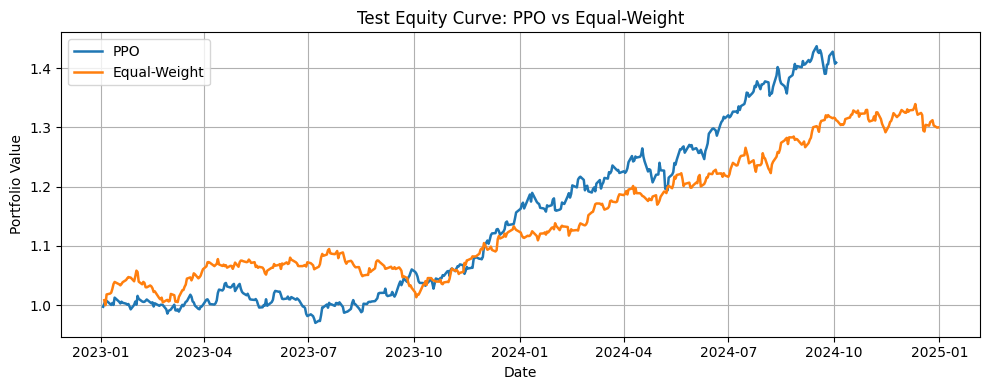

PPO  Sharpe: 2.061
PPO  MDD   : -6.498%
EW   Sharpe: 1.621
EW   MDD   : -7.448%


In [17]:

# --- Align PPO output to test data index ---
# (ensure PPO portfolio value series uses actual test dates)
pv_series.index = prices_test.index[:len(pv_series)]

# === Equal-weight benchmark (daily rebalanced) ===
ew = np.ones(len(TICKERS)) / len(TICKERS)   # equal allocation across all assets
gross_ts = np.exp(logret_test.values)       # convert log returns to gross returns (1+r)

ew_pv = [1.0]  # starting portfolio value
for t in range(gross_ts.shape[0]):
    # dot product gives portfolio daily gross return
    ew_pv.append(ew_pv[-1] * float(np.dot(ew, gross_ts[t])))

ew_series = pd.Series(ew_pv[1:], index=logret_test.index)

# === Plot PPO vs Equal-weight ===
plt.figure(figsize=(10,4))
plt.plot(pv_series, label="PPO", linewidth=1.8)
plt.plot(ew_series, label="Equal-Weight", linewidth=1.8)
plt.title("Test Equity Curve: PPO vs Equal-Weight")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Performance Metrics ===
def sharpe(series, rf=0.0, periods_per_year=252):
    """Annualized Sharpe ratio."""
    ret = series.pct_change().dropna()
    mu = ret.mean() * periods_per_year
    sd = ret.std() * math.sqrt(periods_per_year)
    return float((mu - rf) / (sd + 1e-12))

def max_drawdown(series):
    """Maximum drawdown (as fraction of peak)."""
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return float(dd.min())


# === Print Results ===
print(f"PPO  Sharpe: {sharpe(pv_series):.3f}")
print(f"PPO  MDD   : {max_drawdown(pv_series):.3%}")
print(f"EW   Sharpe: {sharpe(ew_series):.3f}")
print(f"EW   MDD   : {max_drawdown(ew_series):.3%}")
